In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


def load_data():
    mnist = datasets.fetch_openml("mnist_784", version=1, as_frame=False)
    X, y = mnist.data, mnist.target
    y = y.astype(np.int32)  # Convert target to integers
    return X, y


def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


def avg_pooling(image, pool_size):
    pooled_height = image.shape[0] // pool_size[0]
    pooled_width = image.shape[1] // pool_size[1]
    pooled_image = np.zeros((pooled_height, pooled_width))

    for i in range(pooled_height):
        for j in range(pooled_width):
            start_i, end_i = i * pool_size[0], (i + 1) * pool_size[0]
            start_j, end_j = j * pool_size[1], (j + 1) * pool_size[1]
            pooled_image[i, j] = np.mean(image[start_i:end_i, start_j:end_j])

    return pooled_image


def preprocess_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled

In [2]:
def train_model(X_train, y_train):
    model = LogisticRegression(
        max_iter=1000, solver="lbfgs", multi_class="multinomial", random_state=42
    )
    model.fit(X_train, y_train)
    return model

In [3]:
def evaluate_model(pred_func, X_test, y_test):
    y_pred = pred_func(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


def predict(model, new_data):
    predictions = model.predict(new_data)
    return predictions

In [4]:
import tqdm

# Load and split the data
X, y = load_data()

pool_size = 3
X_pooled = np.zeros((X.shape[0], (28 // pool_size) * (28 // pool_size)))
for i in tqdm.tqdm(range(X.shape[0])):
    image = X[i].reshape(28, 28)
    pooled_image = avg_pooling(image, (pool_size, pool_size))
    X_pooled[i] = pooled_image.flatten()

X_train, X_test, y_train, y_test = split_data(X_pooled, y)

# Preprocess the data
X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)

100%|██████████| 70000/70000 [00:17<00:00, 3900.35it/s]


In [5]:
# Train the model
model = train_model(X_train_scaled, y_train)

/Users/robert/miniconda3/envs/neural_bandits/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [6]:
# Evaluate the model
evaluate_model(model.predict, X_test_scaled, y_test)

Accuracy: 0.9142857142857143
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      1343
           1       0.95      0.97      0.96      1600
           2       0.90      0.89      0.90      1380
           3       0.89      0.88      0.88      1433
           4       0.91      0.91      0.91      1295
           5       0.88      0.87      0.87      1273
           6       0.94      0.96      0.95      1396
           7       0.93      0.94      0.93      1503
           8       0.88      0.86      0.87      1357
           9       0.89      0.90      0.90      1420

    accuracy                           0.91     14000
   macro avg       0.91      0.91      0.91     14000
weighted avg       0.91      0.91      0.91     14000

Confusion Matrix:
 [[1289    1    5    4    2   13   18    4    6    1]
 [   0 1549    5    8    1   11    1    5   18    2]
 [   8   17 1232   23   15    7   21   19   32    6]
 [   5   1

In [ ]:
from neural_bandits.algorithms.linear_bandits import LinearUCBBandit


n_samples = 10000
n_features = X_train_scaled.shape[1]
alpha = 0.01
n_arms = 10  # Number of classes
# bandit = LinearTSBandit(n_arms, n_features * n_arms)
bandit = LinearUCBBandit(n_arms, n_features * n_arms)

In [8]:
import torch
from neural_bandits.utils.multiclass import MultiClassContextualiser
from neural_bandits.trainers.linear_trainer import LinearTrainer

mc_contextualiser = MultiClassContextualiser(n_arms)
trainer = LinearTrainer()
total_regret = []
for t in tqdm.tqdm(range(n_samples)):
    x_tensor = torch.tensor(X_train_scaled[t], dtype=torch.float32).reshape(1, -1)
    contextualised_actions = mc_contextualiser.contextualise(x_tensor)
    chosen_arm = torch.argmax(bandit(contextualised_actions), dim=1).item()

    reward = 1 if y_train[t] == chosen_arm else 0
    reward = torch.tensor([reward], dtype=torch.float32)
    total_regret.append(1 - reward.item())

    bandit = trainer.update(
        bandit, reward, contextualised_actions[0, chosen_arm].reshape(1, -1)
    )

print("Total regret:", sum(total_regret))
print("Average regret:", sum(total_regret) / (n_samples))

100%|██████████| 10000/10000 [02:23<00:00, 69.90it/s]

Total regret: 2615.0
Average regret: 0.2615


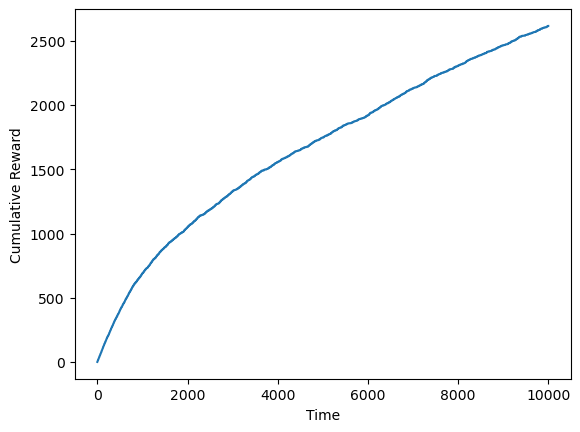

In [9]:
# plot the regret over time
import matplotlib.pyplot as plt

plt.plot(np.cumsum(np.array(total_regret)))
plt.xlabel("Time")
plt.ylabel("Cumulative Reward")
plt.show()

In [ ]:
from neural_bandits.algorithms.linear_bandits import LinearUCBBandit


n_samples = 10000
n_features = X_train_scaled.shape[1]
alpha = 0.01
n_arms = 10  # Number of classes
# bandit = LinearTSBandit(n_arms, n_features * n_arms)
bandit = LinearUCBBandit(n_arms, n_features * n_arms)

In [11]:
batch = 100
buffer_reward = []
buffer_contextualised_actions = []
total_regret_batch = []
for t in tqdm.tqdm(range(n_samples)):
    # for t in tqdm.tqdm(range(1)):
    contextualised_actions = mc_contextualiser.contextualise(
        torch.tensor(X_train_scaled[t], dtype=torch.float32).reshape(1, -1)
    )
    chosen_arm = torch.argmax(bandit(contextualised_actions), dim=1).item()
    reward = 1 if y_train[t] == chosen_arm else 0
    reward = torch.tensor([reward], dtype=torch.float32)
    total_regret_batch.append(1 - reward.item())
    buffer_reward.append(reward)
    buffer_contextualised_actions.append(contextualised_actions[:, chosen_arm])

    if t % batch == batch - 1:
        bandit = trainer.update(
            bandit,
            torch.cat(buffer_reward, dim=0),
            torch.cat(buffer_contextualised_actions, dim=0),
        )
        buffer_reward = []
        buffer_contextualised_actions = []

100%|██████████| 10000/10000 [01:32<00:00, 108.34it/s]


Total regret: 2802.0
Average regret: 0.2802


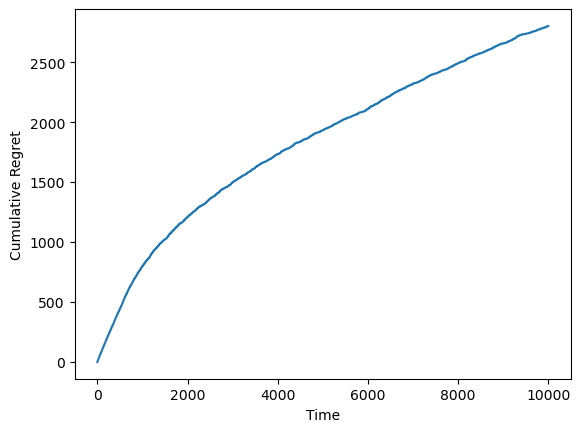

In [12]:
# plot the regret over time
print("Total regret:", sum(total_regret_batch))
print("Average regret:", sum(total_regret_batch) / (n_samples))
plt.plot(np.cumsum(np.array(total_regret_batch)))
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.show()